# Import

In [ ]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [ ]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 1000
scheduler_patience_mapping = {"CIFAR10": 100, "CIFAR100": 100, "ImageNet2012": 30}

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 500
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"

if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [ ]:
file_path

# Loading the dataset

## Define Dateloader

In [ ]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

In [ ]:

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if valid_data is not None:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
else:
    valid_dataloader = None

if test_data is not None:
    test_dataloader = DataLoader(
        test_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("test.transforms =", test_data.transform, test_dataloader.batch_size)
else:
    test_dataloader = None

## Confirm that the dataset is loaded properly

In [ ]:
if test_data is not None:
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis("off")
            count += 1

            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


In [ ]:
# model.named_modules

In [ ]:
# tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
# flops = FlopCountAnalysis(model, tmp_input)
# print(flop_count_table(flops))

# Define Training

## (1) Define Criterion

In [ ]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [ ]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [ ]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_path=file_path)

## (4) Define Learning Rate schedualer

In [ ]:
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_patience_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=100,
)

# scheduler = MultiStepLR(optimizer, milestones=[164, 81], gamma=0.1)
#
"""
=======================================================
non-split : milestones = [164, 81]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k : milestones = [182, 91]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

## (5) Define AMP scaler

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

In [ ]:
optimizer.param_groups[0]["lr"]

# [Training Loop]

In [ ]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [27]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

100%|██████████| 196/196 [00:10<00:00, 18.92it/s]


Train Loss: 0.0011 | Train Acc: 93.75%
Test  Loss: 0.2187 | Test Acc: 93.81%
--------------------------------------------------
[Epoch 827/1000] :


100%|██████████| 196/196 [00:09<00:00, 21.26it/s]


Train Loss: 0.0008 | Train Acc: 95.00%
Test  Loss: 0.2219 | Test Acc: 93.81%
--------------------------------------------------
[Epoch 828/1000] :


100%|██████████| 196/196 [00:09<00:00, 20.27it/s]


Train Loss: 0.0006 | Train Acc: 96.25%
Test  Loss: 0.2180 | Test Acc: 93.80%
--------------------------------------------------
[Epoch 829/1000] :


100%|██████████| 196/196 [00:10<00:00, 18.88it/s]


Train Loss: 0.0007 | Train Acc: 95.00%
Test  Loss: 0.2219 | Test Acc: 93.76%
--------------------------------------------------
[Epoch 830/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.67it/s]


Train Loss: 0.0005 | Train Acc: 93.75%
Test  Loss: 0.2195 | Test Acc: 93.80%
--------------------------------------------------
[Epoch 831/1000] :


100%|██████████| 196/196 [00:09<00:00, 20.22it/s]


Train Loss: 0.0012 | Train Acc: 92.50%
Test  Loss: 0.2253 | Test Acc: 93.77%
--------------------------------------------------
[Epoch 832/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.70it/s]


Train Loss: 0.0008 | Train Acc: 93.75%
Test  Loss: 0.2299 | Test Acc: 93.72%
--------------------------------------------------
[Epoch 833/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.66it/s]


Train Loss: 0.0012 | Train Acc: 91.25%
Test  Loss: 0.2164 | Test Acc: 93.82%
--------------------------------------------------
[Epoch 834/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.87it/s]


Train Loss: 0.0013 | Train Acc: 90.00%
Test  Loss: 0.2220 | Test Acc: 93.80%
--------------------------------------------------
[Epoch 835/1000] :


100%|██████████| 196/196 [00:09<00:00, 20.12it/s]


Train Loss: 0.0011 | Train Acc: 90.00%
Test  Loss: 0.2185 | Test Acc: 93.79%
--------------------------------------------------
[Epoch 836/1000] :


100%|██████████| 196/196 [00:09<00:00, 20.14it/s]


Train Loss: 0.0016 | Train Acc: 88.75%
Test  Loss: 0.2178 | Test Acc: 93.70%
--------------------------------------------------
[Epoch 837/1000] :


100%|██████████| 196/196 [00:10<00:00, 19.00it/s]


Train Loss: 0.0010 | Train Acc: 91.25%
Test  Loss: 0.2301 | Test Acc: 93.68%
--------------------------------------------------
[Epoch 838/1000] :


100%|██████████| 196/196 [00:10<00:00, 18.91it/s]


Train Loss: 0.0010 | Train Acc: 95.00%
Test  Loss: 0.2246 | Test Acc: 93.77%
--------------------------------------------------
[Epoch 839/1000] :


100%|██████████| 196/196 [00:10<00:00, 19.33it/s]


Train Loss: 0.0007 | Train Acc: 96.25%
Test  Loss: 0.2173 | Test Acc: 93.87%
--------------------------------------------------
[Epoch 840/1000] :


100%|██████████| 196/196 [00:09<00:00, 21.03it/s]


Train Loss: 0.0006 | Train Acc: 95.00%
Test  Loss: 0.2194 | Test Acc: 93.81%
--------------------------------------------------
[Epoch 841/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.79it/s]


Train Loss: 0.0005 | Train Acc: 96.25%
Test  Loss: 0.2224 | Test Acc: 93.77%
--------------------------------------------------
[Epoch 842/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.71it/s]


Train Loss: 0.0009 | Train Acc: 92.50%
Test  Loss: 0.2279 | Test Acc: 93.86%
--------------------------------------------------
[Epoch 843/1000] :


100%|██████████| 196/196 [00:10<00:00, 19.02it/s]


Train Loss: 0.0008 | Train Acc: 93.75%
Test  Loss: 0.2200 | Test Acc: 93.74%
--------------------------------------------------
[Epoch 844/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.80it/s]


Train Loss: 0.0006 | Train Acc: 95.00%
Test  Loss: 0.2271 | Test Acc: 93.72%
--------------------------------------------------
[Epoch 845/1000] :


100%|██████████| 196/196 [00:09<00:00, 20.01it/s]


Train Loss: 0.0011 | Train Acc: 96.25%
Test  Loss: 0.2267 | Test Acc: 93.77%
--------------------------------------------------
[Epoch 846/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.97it/s]


Train Loss: 0.0013 | Train Acc: 91.25%
Test  Loss: 0.2219 | Test Acc: 93.78%
--------------------------------------------------
[Epoch 847/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.74it/s]


Train Loss: 0.0007 | Train Acc: 92.50%
Test  Loss: 0.2252 | Test Acc: 93.81%
--------------------------------------------------
[Epoch 848/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.82it/s]


Train Loss: 0.0015 | Train Acc: 88.75%
Test  Loss: 0.2175 | Test Acc: 93.74%
--------------------------------------------------
[Epoch 849/1000] :


100%|██████████| 196/196 [00:09<00:00, 19.84it/s]


Train Loss: 0.0006 | Train Acc: 96.25%
Test  Loss: 0.2192 | Test Acc: 93.81%
--------------------------------------------------
[Epoch 850/1000] :


100%|██████████| 196/196 [00:09<00:00, 20.04it/s]


Train Loss: 0.0007 | Train Acc: 96.25%
Test  Loss: 0.2224 | Test Acc: 93.72%
Early stop!! best_eval_loss = 0.208574132155627


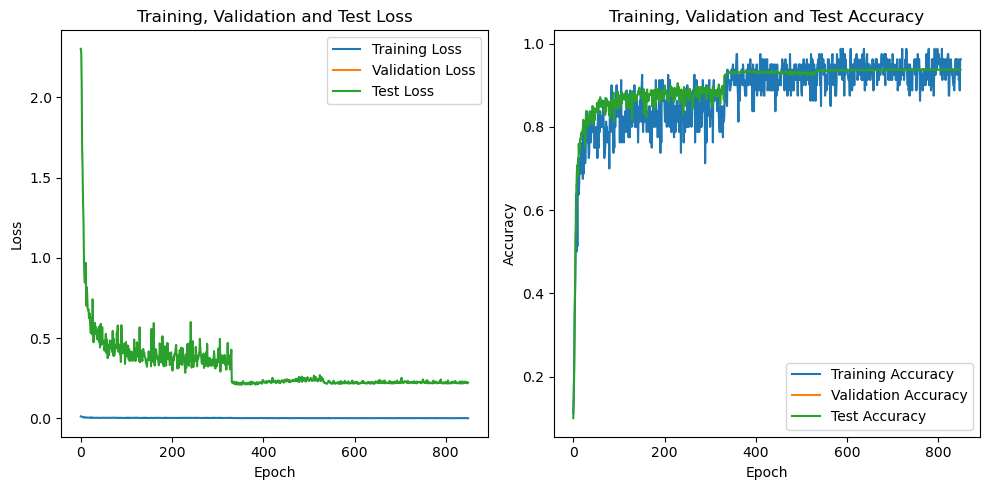

In [28]:
view = LogViewer(logs)
view.draw()

In [29]:
view.print_all()

1 epoch: train_loss=0.0118, train_acc=0.1125, test_loss=2.3033, test_acc=0.1000, lr=0.1000
2 epoch: train_loss=0.0115, train_acc=0.1500, test_loss=2.2808, test_acc=0.1477, lr=0.1000
3 epoch: train_loss=0.0108, train_acc=0.2375, test_loss=2.0899, test_acc=0.2155, lr=0.1000
4 epoch: train_loss=0.0091, train_acc=0.3250, test_loss=1.6819, test_acc=0.3566, lr=0.1000
5 epoch: train_loss=0.0077, train_acc=0.4125, test_loss=1.5537, test_acc=0.4194, lr=0.1000
6 epoch: train_loss=0.0069, train_acc=0.4875, test_loss=1.3479, test_acc=0.5339, lr=0.1000
7 epoch: train_loss=0.0057, train_acc=0.6375, test_loss=1.2257, test_acc=0.5622, lr=0.1000
8 epoch: train_loss=0.0070, train_acc=0.5000, test_loss=0.9877, test_acc=0.6589, lr=0.1000
9 epoch: train_loss=0.0055, train_acc=0.6625, test_loss=0.8844, test_acc=0.6954, lr=0.1000
10 epoch: train_loss=0.0067, train_acc=0.5125, test_loss=0.8453, test_acc=0.7082, lr=0.1000
11 epoch: train_loss=0.0047, train_acc=0.7125, test_loss=0.9487, test_acc=0.6925, lr=0.10

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))